## 目录  
- K折交叉验证    
    - 示例  
- 自动交叉验证   
- 随机拆分交叉验证    
- 分层随机抽样    
- 穷人的网格搜索    
- 暴力网格搜索    
    - 网格搜索  
    - 随机搜索  
- 运用虚拟变量比较模型    
- 评估回归模型    
- 特征选择  
- 运用L1进行特征选择  
- 运用joblib保存模型  
 

In [1]:
import numpy as np
import pandas as pd 
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn

In [2]:
%matplotlib inline

# K折交叉验证
- 仅仅展示了K折是什么，没有具体运用到模型中去

In [3]:
from sklearn.model_selection import KFold

In [4]:
from sklearn.datasets import make_regression
X, y = make_regression(1000, shuffle=True)

In [5]:
# 分离训练集和测试集
N = 1000
holdout = 200

X_h, y_h = X[:holdout], y[:holdout]
X_t, y_t = X[holdout:], y[holdout:]

In [6]:
# 生成KFold对象，4折交叉验证
kfold = KFold(n_splits=4)

In [7]:
# split方法生成将数据集切分为训练集、验证集的索引
output_string = "Fold: {}, N_train: {}, N_test: {}"

for i, (train, test) in enumerate(kfold.split(X_t)):
    print output_string.format(i, len(y_t[train]), len(y_t[test]))

Fold: 0, N_train: 600, N_test: 200
Fold: 1, N_train: 600, N_test: 200
Fold: 2, N_train: 600, N_test: 200
Fold: 3, N_train: 600, N_test: 200


In [8]:
# KFold对象是一个generator对象（生成器），用for循环来调用
type(kfold.split(X_t))

generator

####  示例
长格式的数据集：每个样本占了8行，切分训练集和验证集时需要进行层次切分，即按照病人ID进行切分

In [9]:
# 准备数据集
patients = np.repeat(np.arange(0, 100, dtype=np.int8), 8)
measurements = pd.DataFrame({'patient_id': patients,'ys': np.random.normal(0, 1, 800)})

measurements.head()

,patient_id,ys
0,0,0.802354
1,0,0.480506
2,0,-1.362567
3,0,0.800797
4,0,1.269338


In [10]:
custids = np.unique(measurements.patient_id)  # 病人(按ID考虑的)

customer_kfold = KFold(n_splits=4)
output_string = "Fold: {}, N_train: {}, N_test: {}"
for i, (train, test) in enumerate(customer_kfold.split(custids)):
    train_cust_ids = custids[train]
    # 在measurements数据集上切分成训练集
    training = measurements[measurements.patient_id.isin(train_cust_ids)]
    # 在measurements数据集上切分成验证集
    testing = measurements[~measurements.patient_id.isin(train_cust_ids)]
    print output_string.format(i, len(training), len(testing))

Fold: 0, N_train: 600, N_test: 200
Fold: 1, N_train: 600, N_test: 200
Fold: 2, N_train: 600, N_test: 200
Fold: 3, N_train: 600, N_test: 200


以上两个例子的区别：  
第一个将样本分为训练集和测试集，又进一步将训练集分为训练集和验证集，为6:2:2  
第二个将样本只分为训练集和验证集，没有测试集  

# 自动交叉验证

In [11]:
from sklearn import model_selection

In [12]:
# 创建数据集
from sklearn import datasets
X, y = datasets.make_regression(10000, 10)

In [13]:
# 以随机森林模型作为一个模型应用的示例
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(max_features='auto')

In [14]:
# 默认进行3折交叉验证，为模型评分
scores = model_selection.cross_val_score(rf, X, y)

In [15]:
print scores

[ 0.94297974  0.94073309  0.93987971]


In [16]:
# 设置4折交叉验证，设置verbose显示交叉验证详细过程（每一轮的评分、用时等）
scores = model_selection.cross_val_score(rf, X, y, verbose=3,cv=4)

[CV]  ................................................................
[CV] ....................................... , score=0.946720 -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ....................................... , score=0.941371 -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ....................................... , score=0.943155 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.941873 -   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s finished


# 随机拆分交叉验证

In [17]:
from sklearn import model_selection

In [18]:
# 生成正态分布数据集，N(1000, 10)
true_loc = 1000
true_scale = 10
N = 1000

dataset = np.random.normal(true_loc, true_scale, N)

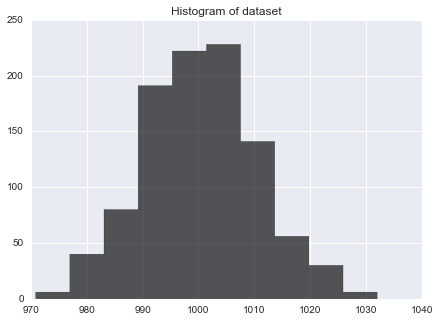

In [19]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))
ax.hist(dataset, color='k', alpha=.65, histtype='stepfilled');

ax.set_title("Histogram of dataset");

#### 直接取一半数据估计均值

In [20]:
# 取数据集中一半样本估计其均值
holdout_set = dataset[:500]
fitting_set = dataset[500:]

In [21]:
estimate = fitting_set[:N/2].mean()

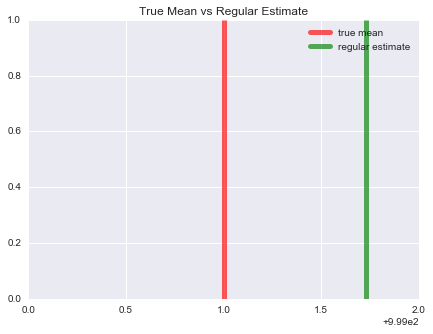

In [22]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.vlines(true_loc, 0, 1, color='r', linestyles='-', lw=5,alpha=.65, label='true mean')
ax.vlines(estimate, 0, 1, color='g', linestyles='-', lw=5,alpha=.65, label='regular estimate')

ax.set_xlim(999, 1001)
ax.set_title("True Mean vs Regular Estimate")
ax.legend()

#### 运用随机拆分

In [23]:
from sklearn.cross_validation import ShuffleSplit

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# 生成ShuffleSplit对象，默认10折（随机选取10%的样本作为验证集，剩下样本作为训练集，如此循环10次）
# 不同于普通交叉验证每一折都是严格区分不重复，随机交叉验证，每一次循环中验证集都是随机选取的，因此有可能重复
shuffle_split = ShuffleSplit(len(fitting_set))

In [25]:
mean_p = []

for train, _ in shuffle_split:
    mean_p.append(fitting_set[train].mean())
    shuf_estimate = np.mean(mean_p)

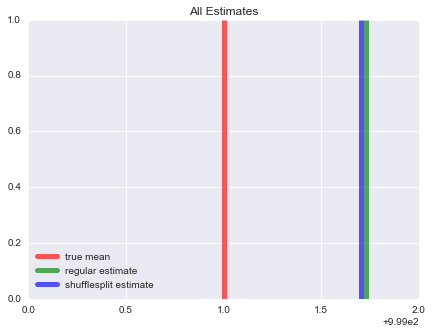

In [26]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.vlines(true_loc, 0, 1, color='r', linestyles='-', lw=5,alpha=.65, label='true mean')
ax.vlines(estimate, 0, 1, color='g', linestyles='-', lw=5,alpha=.65, label='regular estimate')
ax.vlines(shuf_estimate, 0, 1, color='b', linestyles='-', lw=5,alpha=.65, label='shufflesplit estimate')

ax.set_title("All Estimates")
ax.set_xlim(999, 1001)
ax.legend(loc=3)

# 分层随机抽样

In [27]:
from sklearn import model_selection

In [28]:
# 载入分类数据集，类别不平衡
from sklearn import datasets
X, y = datasets.make_classification(n_samples=int(1e3),weights=[1./11])   # 负例：正例 = 1:11

In [29]:
y.mean()

0.90700000000000003

In [30]:
n_splits = 50
strat_kfold = model_selection.StratifiedKFold(n_splits = n_splits)    # 分层随机交叉验证
shuff_split = model_selection.ShuffleSplit(n_splits=n_splits)  # 随机交叉验证

In [31]:
kfold_y_props = []
shuff_y_props = []

for (k_train, k_test), (s_train, s_test) in zip(strat_kfold.split(X, y), shuff_split.split(X)):
    # 分层10折交叉验证
    kfold_y_props.append(y[k_train].mean())
    # 随机10折交叉验证
    shuff_y_props.append(y[s_train].mean())

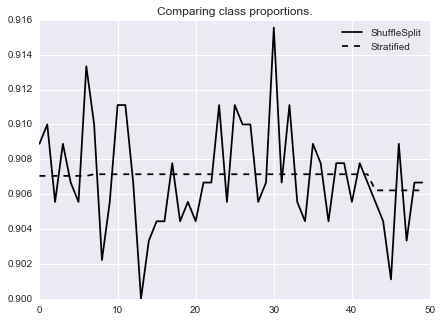

In [32]:
# 随机交叉验证，每一折训练集正例上下波动；分层交叉验证，每一折训练集正例不变
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 5))

ax.plot(range(n_splits), shuff_y_props, label="ShuffleSplit",color='k')
ax.plot(range(n_splits), kfold_y_props, label="Stratified",color='k', ls='--')

ax.set_title("Comparing class proportions.")
ax.legend(loc='best')

In [33]:
import numpy as np
three_classes_X = np.arange(1000)
three_classes_y = np.random.choice([1,2,3], p=[.1, .4, .5],size=1000)

In [34]:
strat_test = model_selection.StratifiedKFold(5)

# np.bincount求出每一次选出的训练集中1、2、3类的样本数，可以看出，每一个训练集的样本类别比例基本保持不变
for train, test in strat_test.split(three_classes_X, three_classes_y):
    print np.bincount(three_classes_y[train])

[  0  70 328 401]
[  0  70 328 401]
[  0  70 328 402]
[  0  71 328 402]
[  0  71 328 402]


# 穷人的网格搜索

In [35]:
# 准备分类数据集
from sklearn import datasets
X, y = datasets.make_classification(n_samples=2000, n_features=10)

In [36]:
# 构造参数空间
criteria = {'gini', 'entropy'}
max_features = {'auto', 'log2', None}

import itertools as it
parameter_space = it.product(criteria, max_features)

In [37]:
# 分离测试集和训练集
import numpy as np
train_set = np.random.choice([True, False], size=len(y))

In [38]:
# 对每一组参数运行决策树模型，并返回预测准确度
from sklearn.tree import DecisionTreeClassifier

accuracies = {}

for criterion, max_feature in parameter_space:
    dt = DecisionTreeClassifier(criterion=criterion,max_features=max_feature)
    dt.fit(X[train_set], y[train_set])
    accuracies[(criterion, max_feature)] = (dt.predict(X[~train_set])== y[~train_set]).mean()
    accuracies

In [39]:
accuracies

{('entropy', None): 0.86852589641434264,
 ('entropy', 'auto'): 0.85458167330677293,
 ('entropy', 'log2'): 0.87549800796812749,
 ('gini', None): 0.85458167330677293,
 ('gini', 'auto'): 0.85557768924302791,
 ('gini', 'log2'): 0.84362549800796816}

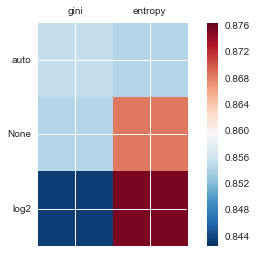

In [40]:
# 通过比较损失函数的大小，在参数空间中选择最优的参数
from matplotlib import pyplot as plt
from matplotlib import cm

cmap = cm.RdBu_r
f, ax = plt.subplots(figsize=(7, 4))
ax.set_xticklabels([''] + list(criteria))
ax.set_yticklabels([''] + list(max_features))

plot_array = []
for max_feature in max_features:
    m = []
    for criterion in criteria:
        m.append(accuracies[(criterion, max_feature)])
    plot_array.append(m)
colors = ax.matshow(plot_array, vmin=np.min(accuracies.values()) -0.001, vmax=np.max(accuracies.values()) + 0.001, cmap=cmap)
f.colorbar(colors)

# 暴力网格搜索

In [41]:
# 准备分类数据
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=5)

In [42]:
# 以逻辑回归模型来说明
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### 网格搜索

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
# 设置网格搜索的参数
grid_search_params = {'penalty': ['l1', 'l2'],'C': [1, 2, 3, 4]}

In [45]:
gs = GridSearchCV(lr, grid_search_params)
gs.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
gs.cv_results_

{'mean_fit_time': array([ 0.00199993,  0.00266671,  0.00366672,  0.0013334 ,  0.00333333,
         0.00100009,  0.        ,  0.        ]),
 'mean_score_time': array([ 0.00033339,  0.        ,  0.00033331,  0.00033339,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'mean_test_score': array([ 0.93 ,  0.929,  0.929,  0.93 ,  0.928,  0.93 ,  0.928,  0.93 ]),
 'mean_train_score': array([ 0.93000422,  0.92950447,  0.92900547,  0.92950447,  0.92900547,
         0.92950447,  0.92900547,  0.92900472]),
 'param_C': masked_array(data = [1 1 2 2 3 3 4 4],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l2' 'l1' 'l2' 'l1' 'l2' 'l1' 'l2'],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1, 'penalty': 'l1'},
  {'C': 1, 'penalty': 'l2'},
  {'C': 2, 'penalty': 'l1'},
  {'C': 2, 'penalty': 'l2'},
  {'C': 3, 'penalty': 'l1'},
  {'

In [47]:
# 用数据框展示
pd.DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002000,0.000333,0.930,0.930004,1,l1,"{u'penalty': u'l1', u'C': 1}",1,0.910180,0.938438,0.930931,0.931034,0.948949,0.920540,1.123916e-07,0.000471,0.015845,0.007343
1,0.002667,0.000000,0.929,0.929504,1,l2,"{u'penalty': u'l2', u'C': 1}",5,0.907186,0.938438,0.930931,0.929535,0.948949,0.920540,1.247129e-03,0.000000,0.017109,0.007307
2,0.003667,0.000333,0.929,0.929005,2,l1,"{u'penalty': u'l1', u'C': 2}",5,0.910180,0.939940,0.930931,0.928036,0.945946,0.919040,1.247150e-03,0.000471,0.014669,0.008560
3,0.001333,0.000333,0.930,0.929504,2,l2,"{u'penalty': u'l2', u'C': 2}",1,0.910180,0.938438,0.930931,0.928036,0.948949,0.922039,4.714266e-04,0.000471,0.015845,0.006775
4,0.003333,0.000000,0.928,0.929005,3,l1,"{u'penalty': u'l1', u'C': 3}",7,0.910180,0.939940,0.927928,0.928036,0.945946,0.919040,4.713704e-04,0.000000,0.014605,0.008560
5,0.001000,0.000000,0.930,0.929504,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.910180,0.938438,0.930931,0.928036,0.948949,0.922039,1.123916e-07,0.000000,0.015845,0.006775
6,0.000000,0.000000,0.928,0.929005,4,l1,"{u'penalty': u'l1', u'C': 4}",7,0.910180,0.939940,0.927928,0.928036,0.945946,0.919040,0.000000e+00,0.000000,0.014605,0.008560
7,0.000000,0.000000,0.930,0.929005,4,l2,"{u'penalty': u'l2', u'C': 4}",1,0.910180,0.938438,0.930931,0.928036,0.948949,0.920540,0.000000e+00,0.000000,0.015845,0.007339


In [48]:
# 返回最优的模型
gs.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### 随机搜索

In [49]:
from sklearn.model_selection import RandomizedSearchCV

In [50]:
# 设置随机搜索的参数
import scipy.stats as st
import numpy as np

# 参数是数值时，可以用分布而不是制定具体数值
random_search_params = {'penalty': ['l1', 'l2'],'C': st.randint(1, 4)}

In [51]:
rs = RandomizedSearchCV(lr,random_search_params)
rs.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000B7A26A0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [52]:
rs.cv_results_

{'mean_fit_time': array([ 0.00333325,  0.00233332,  0.00333325,  0.00133332,  0.00300002,
         0.00066662,  0.        ,  0.        ,  0.        ,  0.        ]),
 'mean_score_time': array([ 0.00100009,  0.00033331,  0.00066678,  0.        ,  0.00033331,
         0.00033339,  0.        ,  0.        ,  0.        ,  0.00533326]),
 'mean_test_score': array([ 0.93 ,  0.928,  0.929,  0.929,  0.929,  0.929,  0.93 ,  0.929,
         0.93 ,  0.928]),
 'mean_train_score': array([ 0.93000422,  0.92900547,  0.92900547,  0.92950447,  0.92900547,
         0.92950447,  0.92950447,  0.92900547,  0.92950447,  0.92900547]),
 'param_C': masked_array(data = [1 3 2 1 2 1 3 2 3 3],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l1' 'l1' 'l2' 'l1' 'l2' 'l2' 'l1' 'l2' 'l1'],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1

In [53]:
pd.DataFrame(rs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.003333,0.001000,0.930,0.930004,1,l1,"{u'penalty': u'l1', u'C': 1}",1,0.910180,0.938438,0.930931,0.931034,0.948949,0.920540,0.001247,0.000817,0.015845,0.007343
1,0.002333,0.000333,0.928,0.929005,3,l1,"{u'penalty': u'l1', u'C': 3}",9,0.910180,0.939940,0.927928,0.928036,0.945946,0.919040,0.000471,0.000471,0.014605,0.008560
2,0.003333,0.000667,0.929,0.929005,2,l1,"{u'penalty': u'l1', u'C': 2}",4,0.910180,0.939940,0.930931,0.928036,0.945946,0.919040,0.000471,0.000471,0.014669,0.008560
3,0.001333,0.000000,0.929,0.929504,1,l2,"{u'penalty': u'l2', u'C': 1}",4,0.907186,0.938438,0.930931,0.929535,0.948949,0.920540,0.000471,0.000000,0.017109,0.007307
4,0.003000,0.000333,0.929,0.929005,2,l1,"{u'penalty': u'l1', u'C': 2}",4,0.910180,0.939940,0.930931,0.928036,0.945946,0.919040,0.000000,0.000471,0.014669,0.008560
5,0.000667,0.000333,0.929,0.929504,1,l2,"{u'penalty': u'l2', u'C': 1}",4,0.907186,0.938438,0.930931,0.929535,0.948949,0.920540,0.000471,0.000471,0.017109,0.007307
6,0.000000,0.000000,0.930,0.929504,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.910180,0.938438,0.930931,0.928036,0.948949,0.922039,0.000000,0.000000,0.015845,0.006775
7,0.000000,0.000000,0.929,0.929005,2,l1,"{u'penalty': u'l1', u'C': 2}",4,0.910180,0.939940,0.930931,0.928036,0.945946,0.919040,0.000000,0.000000,0.014669,0.008560
8,0.000000,0.000000,0.930,0.929504,3,l2,"{u'penalty': u'l2', u'C': 3}",1,0.910180,0.938438,0.930931,0.928036,0.948949,0.922039,0.000000,0.000000,0.015845,0.006775
9,0.000000,0.005333,0.928,0.929005,3,l1,"{u'penalty': u'l1', u'C': 3}",9,0.910180,0.939940,0.927928,0.928036,0.945946,0.919040,0.000000,0.007542,0.014605,0.008560


In [54]:
# 返回最优的模型
rs.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# 运用虚拟变量比较模型

In [55]:
from sklearn import dummy

#### 回归

In [56]:
# 创建回归数据集
from sklearn.datasets import make_regression
X, y = make_regression()

In [57]:
dumdum = dummy.DummyRegressor()
dumdum.fit(X, y)   

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [58]:
dumdum.predict(X)[:5]   # 默认情况下，虚拟模型用均值进行预测

array([ 1.5267656,  1.5267656,  1.5267656,  1.5267656,  1.5267656])

In [59]:
# 有3种预测方式：均值、中位数、常数，选择常数预测方式时，需要指定用来预测的常数
predictors = [("mean", None),("median", None),("constant", 10)]

for strategy, constant in predictors:
    dumdum = dummy.DummyRegressor(strategy=strategy,constant=constant)
    dumdum.fit(X, y)
    print "strategy: {}".format(strategy), ",".join(map(str,dumdum.predict(X)[:5]))

strategy: mean 1.52676559838,1.52676559838,1.52676559838,1.52676559838,1.52676559838
strategy: median 10.6247007466,10.6247007466,10.6247007466,10.6247007466,10.6247007466
strategy: constant 10.0,10.0,10.0,10.0,10.0


#### 分类

In [60]:
# 创建分类数据集
from sklearn.datasets import make_regression, make_classification
X, y = make_classification()

In [61]:
predictors = [("constant", 0),("stratified", None),("uniform", None),("most_frequent", None)]

for strategy, constant in predictors:
    dumdum = dummy.DummyClassifier(strategy=strategy,constant=constant)
    dumdum.fit(X, y)
    print "strategy: {}".format(strategy), ",".join(map(str,dumdum.predict(X)[:5]))

strategy: constant 0,0,0,0,0
strategy: stratified 1,0,0,1,0
strategy: uniform 0,0,1,1,0
strategy: most_frequent 0,0,0,0,0


#### baseline
虚拟回归的作用是建立一个baseline，用后续建立的模型与之进行对比

In [62]:
# 创建不平衡的分类数据集
X, y = make_classification(20000, weights=[.95, .05])

In [63]:
# 将所有测试集中样本预测为多类，从而得到一个baseline
dumdum = dummy.DummyClassifier(strategy='most_frequent')
dumdum.fit(X, y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [64]:
# 后续建立的模型，只有效果比baseline更好，才有意义
from sklearn.metrics import accuracy_score
print accuracy_score(y, dumdum.predict(X))

0.945


# 评估回归模型

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [66]:
# 定义产生回归数据的函数
def data(x, m=2, b=1, e=None, s=10):
    """
    Args:
    x: The x value
    m: Slope
    b: Intercept
    e: Error, optional, True will give random error
    """
    if e is None:
        e_i = 0
    elif e is True:
        e_i = np.random.normal(0, s, len(xs))
    else:
        e_i = e
    return x * m + b + e_i

In [67]:
from functools import partial

In [68]:
N = 100
xs = np.sort(np.random.rand(N)*100)

In [69]:
# 生成y的预测值和真实值
y_pred_gen = partial(data, x=xs, e=True)
y_true_gen = partial(data, x=xs)

y_pred = y_pred_gen()
y_true = y_true_gen()

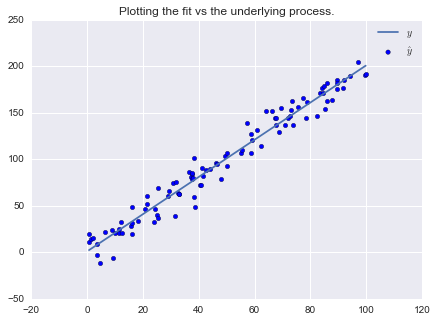

In [70]:
# 点为预测值，直线是数据生成过程，表示真实值
f, ax = plt.subplots(figsize=(7, 5))

ax.scatter(xs, y_pred, label=r'$\hat{y}$')
ax.plot(xs, y_true, label=r'$y$')
ax.set_title("Plotting the fit vs the underlying process.")
ax.legend(loc='best')

In [71]:
# 残差
e_hat = y_pred - y_true

(array([  3.,   2.,   7.,  13.,  11.,  19.,  17.,  18.,   7.,   3.]),
 array([-29.52662471, -24.22168026, -18.9167358 , -13.61179135,
         -8.3068469 ,  -3.00190244,   2.30304201,   7.60798646,
         12.91293092,  18.21787537,  23.52281982]),
 <a list of 1 Patch objects>)

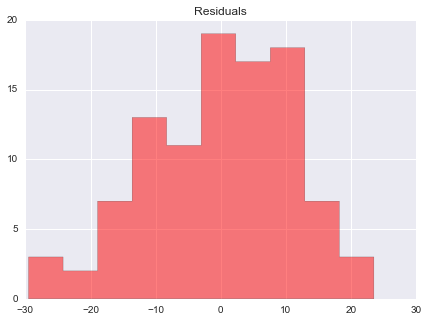

In [72]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Residuals")
ax.hist(e_hat, color='r', alpha=.5, histtype='stepfilled')

#### MSE

In [73]:
from sklearn import metrics
metrics.mean_squared_error(y_true, y_pred)

121.08208606790322

#### MAD

In [74]:
metrics.mean_absolute_error(y_true, y_pred)

8.7678264924217597

#### R-squre

In [75]:
metrics.r2_score(y_true, y_pred)

0.96269628179494304

# 特征选择

In [76]:
from sklearn import feature_selection

In [77]:
from sklearn import datasets
X, y = datasets.make_regression(1000, 10000)

#### F值和P值

In [78]:
f, p = feature_selection.f_regression(X, y)   # f和p是做一元回归时，各个特征的F值和p值

In [79]:
f[:5]

array([ 0.31395866,  3.1032933 ,  0.80640243,  1.45463174,  0.22689219])

In [80]:
p[:5]

array([ 0.57538685,  0.07844024,  0.3694026 ,  0.22807204,  0.63394213])

In [81]:
# 只保留p值小于0.05的特征
import numpy as np
idx = np.arange(0, X.shape[1])
features_to_keep = idx[p < .05]

len(features_to_keep)

485

#### 数据的变异程度
变异程度（方差）大的特征包含更多的信息，且由于这种方法只考虑X而不需要y，因而可用于非监督学习

In [82]:
var_threshold = feature_selection.VarianceThreshold(np.median(np.var(X, axis=1)))  # 取变异程度大于中位数的特征
var_threshold.fit_transform(X).shape

(1000L, 4795L)

In [83]:
# 只有20个特征，便于可视化
X, y = datasets.make_regression(10000, 20)

In [84]:
f, p = feature_selection.f_regression(X, y)

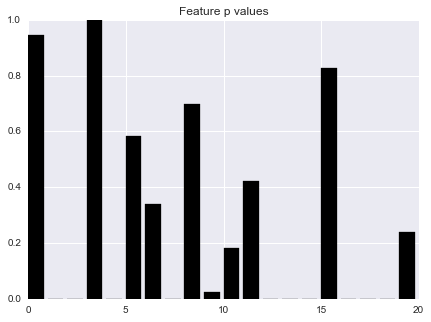

In [85]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(7, 5))
ax.bar(np.arange(20), p, color='k')
ax.set_title("Feature p values")

# L1特征选择

In [86]:
import sklearn.datasets as ds
diabetes = ds.load_diabetes()

#### 采用线性回归，随机划分的交叉验证

In [87]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [88]:
from sklearn import metrics
from sklearn import model_selection

shuff = model_selection.ShuffleSplit(diabetes.target.size)

In [89]:
# 运用交叉验证，求解MSE
mses = []
for train, test in shuff.split(diabetes.data):
    train_X = diabetes.data[train]
    train_y = diabetes.target[train]
    test_X = diabetes.data[~train]
    test_y = diabetes.target[~train]
    lr.fit(train_X, train_y)
    mses.append(metrics.mean_squared_error(test_y,
    lr.predict(test_X)))
np.mean(mses)

2868.0646233127432

#### 运用lasso进行特征选择

In [90]:
from sklearn import feature_selection
from sklearn import model_selection

In [91]:
cv = linear_model.LassoCV()
cv.fit(diabetes.data, diabetes.target)
cv.coef_

array([  -0.        , -226.2375274 ,  526.85738059,  314.44026013,
       -196.92164002,    1.48742026, -151.78054083,  106.52846989,
        530.58541123,   64.50588257])

In [92]:
# 选出系数不为0的特征的索引
import numpy as np
columns = np.arange(diabetes.data.shape[1])[cv.coef_ != 0]
columns

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [93]:
l1mses = []
for train, test in shuff.split(diabetes):
    train_X = diabetes.data[train][:, columns]
    train_y = diabetes.target[train]
    test_X = diabetes.data[~train][:, columns]
    test_y = diabetes.target[~train]
    lr.fit(train_X, train_y)
    l1mses.append(metrics.mean_squared_error(test_y,lr.predict(test_X)))   
np.mean(l1mses)

15095.961538461539

In [94]:
# 比较两个方法的差距，由于数据集中噪声并不多，所以删去一个特征后，模型的MSE有所上升（或略有下降）
np.mean(l1mses) - np.mean(mses)

12227.896915148796

#### 用有噪声的数据集进行试验

In [95]:
X, y = ds.make_regression(noise=5)

In [96]:
mses = []
shuff = model_selection.ShuffleSplit()
for train, test in shuff.split(X):
    train_X = X[train]
    train_y = y[train]
    test_X = X[~train]
    test_y = y[~train]
    lr.fit(train_X, train_y)
    mses.append(metrics.mean_squared_error(test_y,lr.predict(test_X)))
np.mean(mses)

235.93187522140914

In [97]:
cv.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [98]:
import numpy as np
columns = np.arange(X.shape[1])[cv.coef_ != 0]
columns[:5]

array([ 2,  6,  7,  9, 12], dtype=int64)

In [99]:
mses = []
shuff = model_selection.ShuffleSplit()
for train, test in shuff.split(X):
    train_X = X[train][:, columns]
    train_y = y[train]
    test_X = X[~train][:, columns]
    test_y = y[~train]
    lr.fit(train_X, train_y)
    mses.append(metrics.mean_squared_error(test_y,lr.predict(test_X)))
np.mean(mses)

13.37873490551903

可以看出，MSE有很大的降低，说明了特征选择的有用性

# 用joblib保存模型

In [100]:
from sklearn.externals import joblib

In [101]:
# 准备数据，并生成决策树模型
from sklearn import datasets, tree

X, y = datasets.make_classification()

dt = tree.DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [102]:
# 保存该模型
joblib.dump(dt, "dtree.clf")

['dtree.clf']

In [103]:
# 建立随机森林模型
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [104]:
# 保存该模型
joblib.dump(rf, "rf.clf")

['rf.clf']